/home/sweetyalekya/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sweetyalekya/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|█████████████████████████████████████████████████████████| 490/490 [09:15<00:00,  1.13s/it, loss=0.359]


Epoch 1: Train Loss: 0.3590, Val Loss: 0.2777, Val Acc: 0.8982


Epoch 2/10: 100%|█████████████████████████████████████████████████████████| 490/490 [58:16<00:00,  7.14s/it, loss=0.244]


Epoch 2: Train Loss: 0.2437, Val Loss: 0.2537, Val Acc: 0.8997


Epoch 3/10: 100%|█████████████████████████████████████████████████████████| 490/490 [36:22<00:00,  4.45s/it, loss=0.198]


Epoch 3: Train Loss: 0.1981, Val Loss: 0.3267, Val Acc: 0.8446


Epoch 4/10: 100%|█████████████████████████████████████████████████████████| 490/490 [07:45<00:00,  1.05it/s, loss=0.161]


Epoch 4: Train Loss: 0.1612, Val Loss: 0.3042, Val Acc: 0.8844


Epoch 5/10: 100%|█████████████████████████████████████████████████████████| 490/490 [19:21<00:00,  2.37s/it, loss=0.115]


Epoch 5: Train Loss: 0.1153, Val Loss: 0.1878, Val Acc: 0.9357


Epoch 6/10: 100%|█████████████████████████████████████████████████████████| 490/490 [08:06<00:00,  1.01it/s, loss=0.107]


Epoch 6: Train Loss: 0.1074, Val Loss: 0.1378, Val Acc: 0.9548


Epoch 7/10: 100%|█████████████████████████████████████████████████████████| 490/490 [08:07<00:00,  1.01it/s, loss=0.101]


Epoch 7: Train Loss: 0.1011, Val Loss: 0.1777, Val Acc: 0.9372


Epoch 8/10: 100%|████████████████████████████████████████████████████████| 490/490 [08:12<00:00,  1.01s/it, loss=0.0738]


Epoch 8: Train Loss: 0.0738, Val Loss: 0.1573, Val Acc: 0.9426


Epoch 9/10: 100%|████████████████████████████████████████████████████████| 490/490 [07:46<00:00,  1.05it/s, loss=0.0756]


Epoch 9: Train Loss: 0.0756, Val Loss: 0.1253, Val Acc: 0.9571


Epoch 10/10: 100%|███████████████████████████████████████████████████████| 490/490 [08:23<00:00,  1.03s/it, loss=0.0638]


Epoch 10: Train Loss: 0.0638, Val Loss: 0.6212, Val Acc: 0.7489


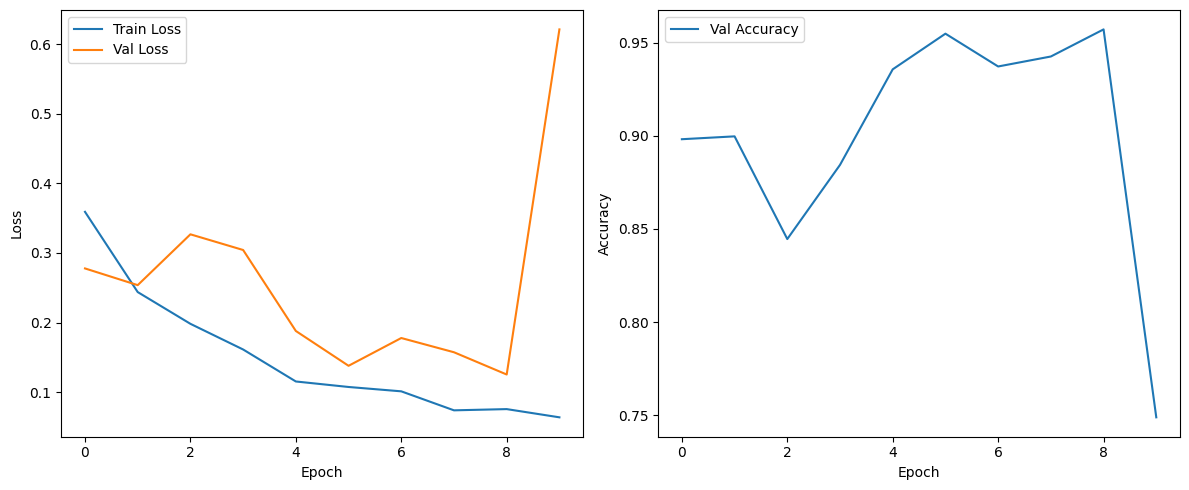

/tmp/ipykernel_58870/1393951203.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Test Metrics:
Accuracy: 0.9449
Precision: 0.9623
Recall: 0.9743
F1-Score: 0.9683


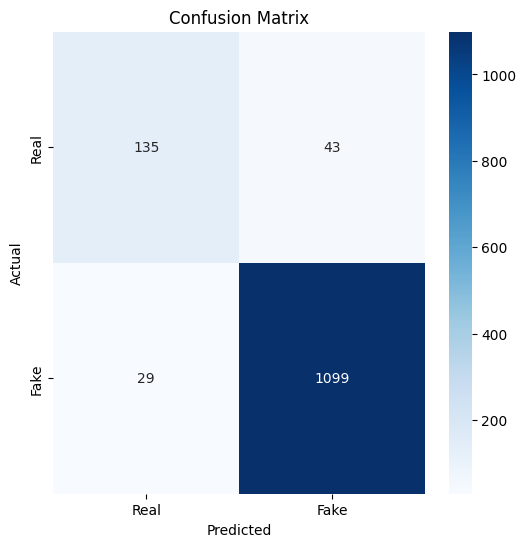

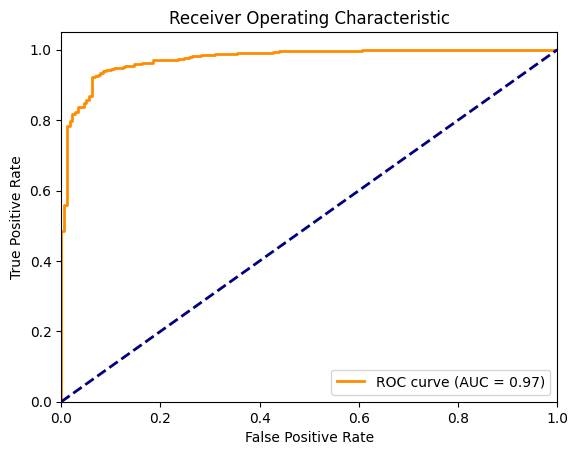


Example Detections:


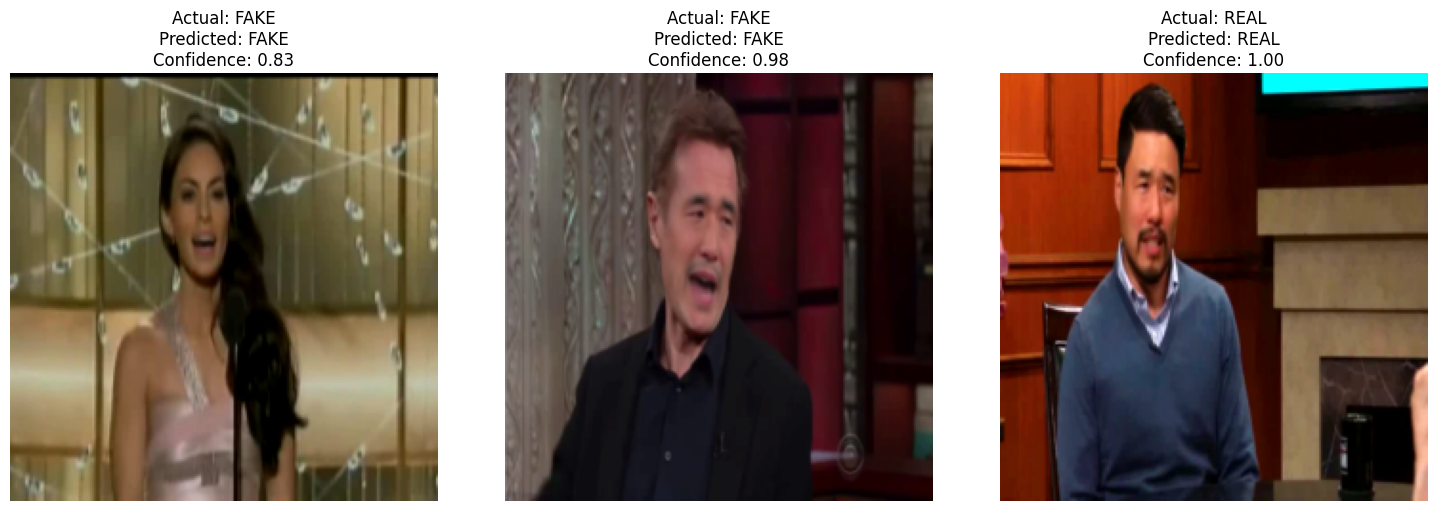

In [6]:
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, auc, precision_score, 
                            recall_score, f1_score, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Verified paths for WSL environment
base_path = Path("/mnt/c/Users/USER/Downloads/archive (3)")
REAL_VIDEOS = base_path / "Celeb-real"
FAKE_VIDEOS = base_path / "Celeb-synthesis"
YOUTUBE_REAL = base_path / "YouTube-real"

# Get all video paths
real_videos = list(YOUTUBE_REAL.glob("*.mp4")) + list(REAL_VIDEOS.glob("*.mp4"))
fake_videos = list(FAKE_VIDEOS.glob("*.mp4"))

# Prepare dataset
video_paths = [str(p) for p in real_videos + fake_videos]
labels = [0] * len(real_videos) + [1] * len(fake_videos)

# Split dataset
train_videos, test_videos, train_labels, test_labels = train_test_split(
    video_paths, labels, test_size=0.2, stratify=labels, random_state=42
)
train_videos, val_videos, train_labels, val_labels = train_test_split(
    train_videos, train_labels, test_size=0.25, stratify=train_labels, random_state=42
)

# Dataset class
class VideoDataset(Dataset):
    def __init__(self, video_paths, labels, transform=None, frame_interval=30, max_frames=10):
        self.video_paths = video_paths
        self.labels = labels
        self.transform = transform
        self.frame_interval = frame_interval
        self.max_frames = max_frames
        
    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]
        
        cap = cv2.VideoCapture(video_path)
        frames = []
        count = 0
        
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
                
            if count % self.frame_interval == 0:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                
                if self.transform:
                    frame = self.transform(frame)
                    
                frames.append(frame)
            
            count += 1
            if len(frames) >= self.max_frames:
                break
                
        cap.release()
        
        # Pad or trim to max_frames
        if len(frames) < self.max_frames:
            pad_frame = torch.zeros_like(frames[0]) if frames else torch.zeros((3, 224, 224))
            frames += [pad_frame] * (self.max_frames - len(frames))
        else:
            frames = frames[:self.max_frames]
            
        frames = torch.stack(frames)
        return frames, torch.tensor(label, dtype=torch.long)

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = VideoDataset(train_videos, train_labels, transform=transform)
val_dataset = VideoDataset(val_videos, val_labels, transform=transform)
test_dataset = VideoDataset(test_videos, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

# Model definition
class DeepfakeDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 2)
        
    def forward(self, x):
        batch_size, num_frames, C, H, W = x.shape
        x = x.view(batch_size * num_frames, C, H, W)
        features = self.resnet(x)
        features = features.view(batch_size, num_frames, -1)
        return features.mean(dim=1)

model = DeepfakeDetector().to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        
        for videos, labels in progress_bar:
            videos, labels = videos.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(videos)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            progress_bar.set_postfix({'loss': train_loss/(progress_bar.n+1)})
        
        # Validation
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        scheduler.step(val_loss)
        
        history['train_loss'].append(train_loss/len(train_loader))
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}: Train Loss: {history["train_loss"][-1]:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            
    return history

# Evaluation function
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for videos, labels in loader:
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return running_loss / len(loader), correct / total

# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

# Plot learning curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Full evaluation
def full_evaluation(model, loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for videos, labels in loader:
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend((probs > 0.5).cpu().numpy().astype(int))
    
    return all_labels, all_preds, all_probs

test_labels, test_preds, test_probs = full_evaluation(model, test_loader)

# Calculate metrics
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)
test_acc = np.mean(np.array(test_labels) == np.array(test_preds))

print("\nTest Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(test_labels, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

# Example detections
def show_detection_examples(model, loader, num_examples=3):
    model.eval()
    examples = []
    
    with torch.no_grad():
        for videos, labels in loader:
            videos = videos.to(device)
            outputs = model(videos)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            
            for i in range(min(num_examples, videos.size(0))):
                frame = videos[i, 0].cpu().numpy().transpose((1, 2, 0))
                frame = (frame * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
                frame = np.clip(frame, 0, 255).astype('uint8')
                
                label = labels[i].item()
                pred = probs[i].item()
                pred_label = "FAKE" if pred > 0.5 else "REAL"
                confidence = pred if pred > 0.5 else 1 - pred
                
                examples.append((frame, label, pred_label, confidence))
                
                if len(examples) >= num_examples:
                    break
            if len(examples) >= num_examples:
                break
    
    plt.figure(figsize=(15, 5))
    for i, (frame, label, pred_label, confidence) in enumerate(examples):
        plt.subplot(1, num_examples, i+1)
        plt.imshow(frame)
        plt.title(f'Actual: {"FAKE" if label else "REAL"}\n'
                 f'Predicted: {pred_label}\n'
                 f'Confidence: {confidence:.2f}')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('detection_examples.png')
    plt.show()

print("\nExample Detections:")
show_detection_examples(model, test_loader)